<html>
<div>
  <span style="font-family: Poppins; font-size:30px; color: white;"> <br/> University of Tehran <br/> CA3
</div>
<span style="font-family: Poppins; font-size:15pt; color: white; vertical-align: middle;"> Mahdi Noori </span><br>
<span style="font-family: Poppins; font-size:15pt; color: white; vertical-align: middle;"> 810100231 </span>

</html>

## Goal
in this notebook we learn HMM models and how to use it for sound classification using the features that can be extracted from the audio.

## Problem Description
in this problem we are given several audios in 4 genres (blues, metal, hiphop and pop) and using HMM model we will train a model on the provided dataset for classifying each audio and then analize the model performance.
the classification happens based on MFCC of each audio which can provide fairly good information for this classification.

## Imports

In [1]:
import numpy as np
from pathlib import Path
import glob
from helper import extract_mfcc_plot_data,plot_mfcc_heatmap ,mfcc_calculator,confusion_matrix_generator,plot_confusion_matrix,precision_score,recall_score,f1_score,accuracy_score,accuracy_single,precision_single,recall_single,f1_score_single
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,StandardScaler
from scipy.stats import multivariate_normal

# Section 1: MFCC

### Q1 : 
- Many machine learning models accept fixed-length inputs. by having all samples with the same length we can create a consistent input shape for the model we are using.

- When training a model we can process the data in batches and it is a common way for processing. having samples with the same length makes batch processing effecient.

- Having samples of the same length makes the preprocessing steps easier. we don't need to consider variable-length sequences.

- Because MFCCs often computed over fixed-length audios having inputs with same length helps comparing the extracted feature across dufferent samples.

### Extracting MFCC coefficients
Here for each genre we have :<br>
1. using the function ```extract_mfcc_plot_data``` in ```helper.py``` we extract the mfcc coefficeints. this function takes the audio file names and then loads them and then using the ```mfcc_calculator``` also in ```helper.py``` claculates the features for each audio. (note that because the frame sizes are different we cut all audios to the smallest frame size)
2. using the function ```plot_mfcc_heatmap``` in ```helper.py``` we plot the heatmap for the first audio of each genre.

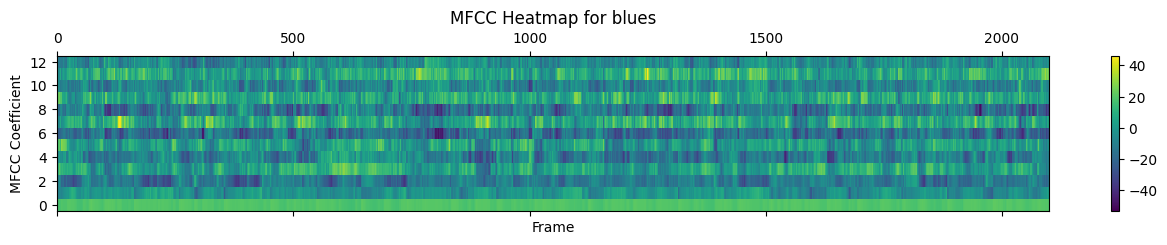

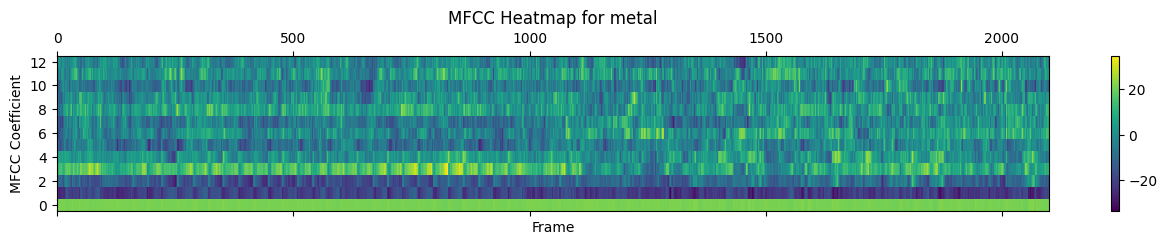

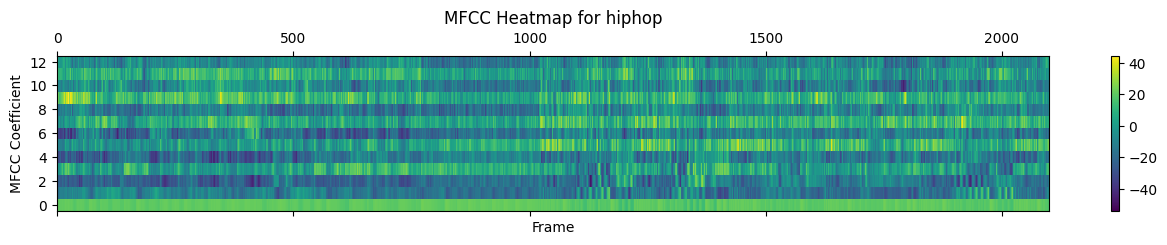

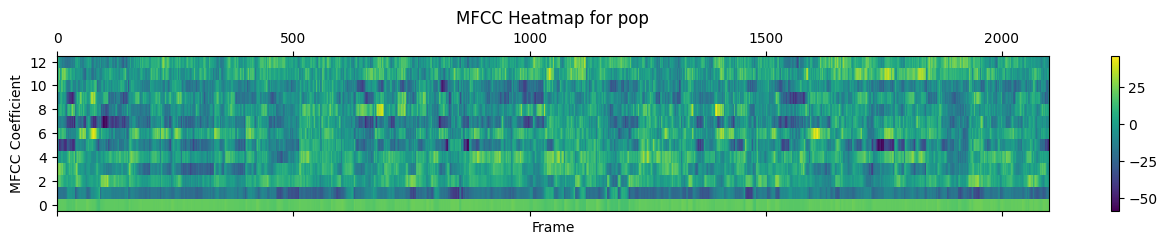

In [3]:
genres_list=["blues","metal","hiphop","pop"]
for genre in genres_list:

    folder_path = f"{Path().absolute()}/samples/{genre}/*.wav"
    wav_files = glob.glob(folder_path)
    mfccs_array = extract_mfcc_plot_data(wav_files)
    plot_mfcc_heatmap(genre,mfccs_array)


### Q2:
using overlapping frames in MFCC helps to get the changes of the audio signal over time, reduce variability, and create a smoother representation that is good enough for different audio analysis tasks.

### Q3:
- The first few MFCCs often capture the most noticable and important features related to the spectral shape and energy distribution of the audio. so by using fewer frames we can reduce the dimensity of features and it can be beneficial for computational time.

- By focusing on the first 12 or 13 MFCC, we can capture the most perceptually relevant information and redundant information. because researches have shown that humans are more sensetive to lower-order MFCCs.

<!-- Mel filterbank resolution: The Mel filterbank used in the computation of MFCCs is designed to mimic the human auditory system's frequency resolution. The number of Mel filters determines the frequency resolution of the filterbank. By using a smaller number of MFCCs, we effectively limit the frequency resolution and discard higher-frequency components that may have less perceptual relevance or be more sensitive to noise. -->

# Section 2: HMM

### Q1:
- States : unobservable or hidden variables of the system.
- Observation : observable variables or evidence that is available to us.<br>

Here states are music categories ```blues``` ,```metal``` ,```hiphop``` and ```pop```.
Here the observations are derived from the audio signals. the process of obtaining observations involves extracting relevant features from the audio signal. here we are using MFCC for retrieving the features.

### Q2:
It is called first-order because the current state depends only on the previous state. <br>
It assumes that the probability of transitioning to a particular state depends only on the previous state. this can be represented as $P(state_t | state_{t-1})$.<br>
The difference between each category is in the previous states that it depends on. for example in a second-order model the probability depends on two last states.

### Q3:
HMMs are useful when working with sequential data like a series of events or a time series. They are good at capturing the relationships between these events and can help us understand how things change over time.
HMMs are especially helpful when the data we have is not complete or is noisy. HMMs can handle this kind of imperfect data and still make reasonable predictions or estimates based on what we do have. HMMs are beneficial when there are hidden factors or states that affect the observed data.

Some of the use cases are :
- ```speech recognition``` : HMMs can capture the temporal dependencies in speech signals.

- ```NLP``` : HMMs can model the sequential nature of language and capture the dependencies between different words.

- ```gesture recognition``` : HMMs can handle noisy and variable-length input sequences making them suitable for gesture recognition tasks.
- ```financial time series analysis```:  HMMs can capture the temporal dependencies and provide insights into market behavior.

### Q4:
```Pros```: 
- HMMs provide a probabilistic framework for modeling sequential data and it can capture the uncertainities and so the model is more robust.
- it can capture sequential dependencies in data. so it is useful for time-series data analysis.
- HMMs can handle missing data . using the forward-backward algorithm which can estimate the probability distribution of missing states or observations.
- HMMs provide a compact representation of the system so it is beneficial for computational resources.<br>

```Cons```: 
- HMMs assume that the observations are conditionally independent given the hidden states. This assumption may not be correct in some real-world scenario.
- fixed state space in HMMs can limit the model ability to handle situations where the number or nature of states may change.
- HMMs are sensitive to the choice of initial parameters and incorrect initialization may result in convergence to suboptimal.
- The model forget the past states as the sequence length increases which can limit its effectiveness in tasks that need a long-term memory.

### Q5:
1. discrete HMM: In a discrete HMM the hidden states and the observations are discrete variables. this means that the hidden states have a finite set of values and the observations also belong to a discrete set. DHMMs are mostly used in applications such as part-of-speech tagging.

2. continuous HMM: In a continuous HMM the observations are continuous variables and mostly modeled by probability density functions such as Gaussian distribution. CHMMs are often used in applications involving continuous data, such as speech recognition where features are represented as continuous variables.

3. left to right HMM : In this type the model transitions from one state to the next in a fixed left to right order. this type of HMM is useful when the process has a temporal ordering and the system evolves in a sequential manner.

### Here we make our data set ready for train and test :<br>
First get the ```mfcc``` for each file and its corresponding label and add them to our dataset. then we split our data to ```train``` and ```test``` data for each genre using ```sklearn```'s ```train_test_split```. we use $70\% $ of the data for each genre in training phase and $30\% $ for testing.

In [4]:
labels=["blues","metal","hiphop","pop"]
train_dict=dict()
test_x=np.array([])
test_y=np.array([])

for label in labels:
    X=[]
    Y=[]
    folder_path = f"{Path().absolute()}/samples/{label}/*.wav"
    wav_files = glob.glob(folder_path)
    for audio_file in wav_files:
        mfccs=mfcc_calculator(audio_file)
        X.append(mfccs)
        Y.append(labels.index(label))
    X=np.array(X)
    
    X_train, X_test, y_train, y_test = train_test_split(X, np.array(Y), test_size=0.3, random_state=42)
    train_dict[label]=X_train.reshape((X_train.shape[0]*X_train.shape[1],X_train.shape[2]))
    if len(test_x)==0:
        test_x=X_test
        test_y=y_test
    else:
        test_x=np.concatenate((test_x, X_test), axis=0)
        test_y=np.concatenate((test_y, y_test), axis=0)


## Implementing with library
Here we are using the ```GaussianHMM``` model. we train a model for each genre. each genre will be trained with its corresponding train data.

In [5]:
from hmmlearn import hmm

hmm_models=[]

for label in labels:
    model = hmm.GaussianHMM(n_components=4, covariance_type='diag')
    model.fit(train_dict[label])
    hmm_models.append(model)

Now for test we label each audio in test data. here we give the audio to all of our models. the one with biggest score would label the data.

In [6]:
y_preds_library=[]
for i in range(test_x.shape[0]):
    scores=[]
    for model in hmm_models:
        scores.append(model.score(test_x[i,:]))
    label = np.argmax(np.array(scores))
    y_preds_library.append(label)

## Implementing from scratch

In [6]:
class HMM:
    def __init__(self, num_hidden_states):
        self.num_hidden_states = num_hidden_states
        self.rand_state = np.random.RandomState(1)

        self.initial_prob = self._normalize(self.rand_state.rand(self.num_hidden_states, 1))
        self.transition_matrix = self._stochasticize(self.rand_state.rand(self.num_hidden_states, self.num_hidden_states))

        self.mean = None
        self.covariances = None
        self.num_dimensions = None

    def _forward(self, observation_matrix):
        log_likelihood = 0.
        T = observation_matrix.shape[1]
        alpha = np.zeros(observation_matrix.shape)

        for t in range(T):
            if t == 0:
                alpha[:, t] = observation_matrix[:, 0] * self.initial_prob[:, 0] 
            else:
                alpha[:, t] = np.matmul(self.transition_matrix.T, alpha[:, t-1]) * observation_matrix[:, t]

            alpha_sum = np.sum(alpha[:, t])
            alpha[:, t] /= alpha_sum
            log_likelihood += np.log(alpha_sum)

        return log_likelihood, alpha

    def _backward(self, observation_matrix):
        T = observation_matrix.shape[1]
        beta = np.zeros(observation_matrix.shape)

        beta[:, -1] = np.ones(observation_matrix.shape[0])

        for t in range(T - 1)[::-1]:
            beta[:, t] = np.matmul(self.transition_matrix, (observation_matrix[:, t+1] * beta[:, t+1]))
            beta[:, t] /= np.sum(beta[:, t])

        return beta

    def _state_likelihood(self, obs):
        obs = np.atleast_2d(obs)
        B = np.zeros((self.num_hidden_states, obs.shape[1]))

        for s in range(self.num_hidden_states):
            np.random.seed(self.rand_state.randint(1))
            B[s, :] = multivariate_normal.pdf(obs.T,mean =self.mean[:,s],cov = self.covariances[:,:,s])
        return B

    def _normalize(self, x):
        return (x + (x == 0)) / np.sum(x)

    def _stochasticize(self, x):
        return (x + (x == 0)) / np.sum(x, axis=1)

    def _em_init(self, obs):
        if self.num_dimensions is None:
            self.num_dimensions = obs.shape[0]
        if self.mean is None:
            subset = self.rand_state.choice(np.arange(self.num_dimensions), size=self.num_hidden_states, replace=False)
            self.mean = obs[:, subset]
        if self.covariances is None:
            self.covariances = np.zeros((self.num_dimensions, self.num_dimensions, self.num_hidden_states))
            self.covariances += np.diag(np.diag(np.cov(obs)))[:, :, None]

        return self

    def _em_step(self, obs):
        obs = np.atleast_2d(obs)
        T = obs.shape[1]

        B = self._state_likelihood(obs)

        log_likelihood, alpha = self._forward(B)
        beta = self._backward(B)

        xi_sum = np.zeros((self.num_hidden_states, self.num_hidden_states))
        gamma = np.zeros((self.num_hidden_states, T))

        for t in range(T - 1):
            partial_sum = np.sum(np.matmul(alpha[:, t], beta[:, t+1].T)*B[:, t+1])*self.transition_matrix
            xi_sum += self._normalize(partial_sum)
            partial_g = alpha[:, t] * beta[:, t]
            gamma[:, t] = self._normalize(partial_g)
        partial_g = alpha[:, T-1] * beta[:, T-1]
        gamma[:, -1] = self._normalize(partial_g)

        expected_prior = np.reshape(gamma[:, 0],(-1,1))
        expected_transition = self._stochasticize(xi_sum/np.sum(xi_sum, axis=(0, 1)))

        expected_covariances = np.zeros((self.num_dimensions, self.num_dimensions, self.num_hidden_states))
        expected_covariances += .01 * np.eye(self.num_dimensions)[:, :, None]

        gamma_state_sum = np.sum(gamma, axis=1)
        gamma_state_sum = gamma_state_sum + (gamma_state_sum == 0)

        expected_mean = np.zeros((self.num_dimensions, self.num_hidden_states))
        for s in range(self.num_hidden_states):
            gamma_obs = obs * gamma[s, :]
            expected_mean[:, s] = np.sum(gamma_obs, axis=1) / gamma_state_sum[s]

        self.initial_prob = expected_prior
        self.mean = expected_mean
        self.covariances = expected_covariances
        self.transition_matrix = expected_transition

        return log_likelihood

    def train(self, obs, num_iterations=1):
        for i in range(num_iterations):
            self._em_init(obs)
            self._em_step(obs)
        return self

    def score(self, obs):
        B = self._state_likelihood(obs)
        log_likelihood, _ = self._forward(B)
        return log_likelihood


Here like above for each genre we train a model and then predict the test data with them.

In [7]:
hmm_models = []

for label in labels:
    model = HMM(num_hidden_states=4)
    model.train(train_dict[label].T/np.amax(train_dict[label].T),num_iterations=2)
    hmm_models.append(model)


In [8]:
y_preds_scratch=[]
for i in range(test_x.shape[0]):
    scores=[]
    for model in hmm_models:
        scores.append(model.score(test_x[i,:].T/np.amax(test_x[i,:].T)))
    label = np.argmax(np.array(scores))
    y_preds_scratch.append(label)

# Analysis of the models

In this section we use ```accuracy_score```,```confusion_matrix_generator```,```precision_score```,```recall_score``` and ```f1_score``` in ```helper.py``` for calculating the metrics.
- ```confusion_matrix_generator``` : this function recieves the predicted labels and real ones and the number of classes and generates the confusion matrix.
- ```accuracy_score``` : his function recieves the predicted labels and real ones and returns the accuracy.
- ```precision_score``` : this function recieves the predicted labels and real ones and the number of classes and returns the precision. it can calculate this metric with the desired average method.
- ```recall_score``` : this function recieves the predicted labels and real ones and the number of classes and returns the recall. it can calculate this metric with the desired average method.
- ```f1_score``` : this function recieves the predicted labels and real ones and the number of classes and returns the f1_score. it can calculate this metric with the desired average method.

all of the metrics have a single extension which is for calculating the metrics for single classes.

### First we anlyze the ```hmmlearn``` model


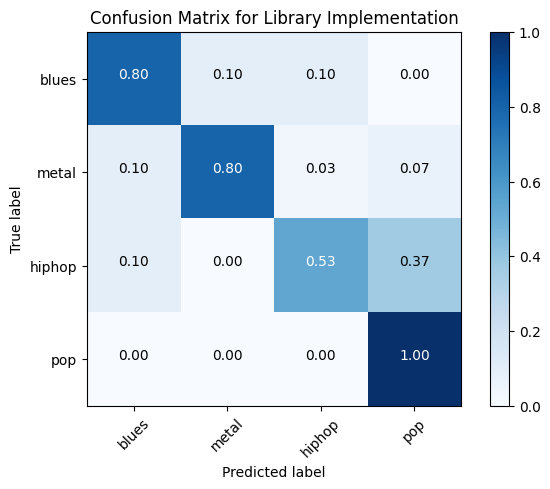

The accuracy of the model is 0.78
The accuracy in blues class is 0.90
The precision in blues class is 0.80
The recall in blues class is 0.80
The f1_score in blues class is 0.80
The accuracy in metal class is 0.93
The precision in metal class is 0.89
The recall in metal class is 0.80
The f1_score in metal class is 0.84
The accuracy in hiphop class is 0.85
The precision in hiphop class is 0.80
The recall in hiphop class is 0.53
The f1_score in hiphop class is 0.64
The accuracy in pop class is 0.89
The precision in pop class is 0.70
The recall in pop class is 1.00
The f1_score in pop class is 0.82
The precision in macro method is 0.80
The recall in macro method is 0.78
The f1_score in macro method is 0.79
The precision in micro method is 0.78
The recall in micro method is 0.78
The f1_score in micro method is 0.78
The precision in weighted method is 0.80
The recall in weighted method is 0.78
The f1_score in weighted method is 0.79


In [7]:
cm = confusion_matrix_generator(test_y, np.array(y_preds_library), 4)
plot_confusion_matrix(cm, labels, "Confusion Matrix for Library Implementation")
average_methods=["macro","micro","weighted"]

print(f"The accuracy of the model is {accuracy_score(test_y, np.array(y_preds_library)):.2f}")

for label in labels:
    print(f"The accuracy in {label} class is {accuracy_single(test_y, np.array(y_preds_library), labels.index(label)):.2f}")
    print(f"The precision in {label} class is {precision_single(test_y, np.array(y_preds_library), labels.index(label)):.2f}")
    print(f"The recall in {label} class is {recall_single(test_y, np.array(y_preds_library), labels.index(label)):.2f}")
    print(f"The f1_score in {label} class is {f1_score_single(test_y, np.array(y_preds_library), labels.index(label)):.2f}")

    

for method in average_methods:
    print(f"The precision in {method} method is {precision_score(test_y, np.array(y_preds_library), 4, average_method=method):.2f}")
    print(f"The recall in {method} method is {recall_score(test_y, np.array(y_preds_library), 4, average_method=method):.2f}")
    print(f"The f1_score in {method} method is {f1_score(test_y, np.array(y_preds_library),  average_method=method):.2f}")


### Now for the ```From Scratch``` model

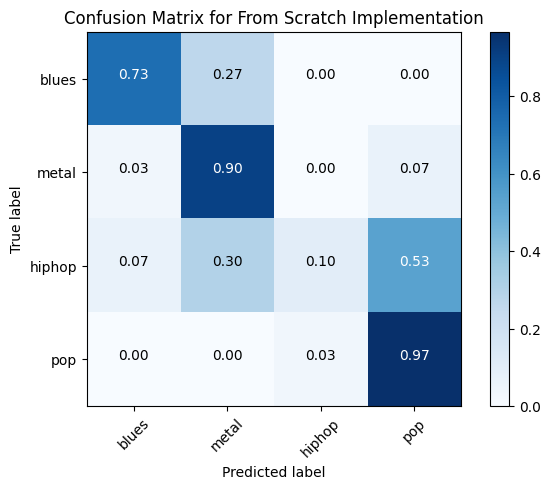

The accuracy is 0.68
The accuracy in blues class is 0.91
The precision in blues class is 0.88
The recall in blues class is 0.73
The f1_score in blues class is 0.80
The accuracy in metal class is 0.83
The precision in metal class is 0.61
The recall in metal class is 0.90
The f1_score in metal class is 0.73
The accuracy in hiphop class is 0.77
The precision in hiphop class is 0.75
The recall in hiphop class is 0.10
The f1_score in hiphop class is 0.18
The accuracy in pop class is 0.84
The precision in pop class is 0.62
The recall in pop class is 0.97
The f1_score in pop class is 0.75
The precision in macro method is 0.72
The recall in macro method is 0.68
The f1_score in macro method is 0.69
The precision in micro method is 0.68
The recall in micro method is 0.68
The f1_score in micro method is 0.68
The precision in weighted method is 0.72
The recall in weighted method is 0.68
The f1_score in weighted method is 0.69


In [10]:
cm = confusion_matrix_generator(test_y, np.array(y_preds_scratch), 4)
plot_confusion_matrix(cm, labels, "Confusion Matrix for From Scratch Implementation")
average_methods=["macro","micro","weighted"]

print(f"The accuracy is {accuracy_score(test_y, np.array(y_preds_scratch)):.2f}")

for label in labels:
    print(f"The accuracy in {label} class is {accuracy_single(test_y, np.array(y_preds_scratch), labels.index(label)):.2f}")
    print(f"The precision in {label} class is {precision_single(test_y, np.array(y_preds_scratch), labels.index(label)):.2f}")
    print(f"The recall in {label} class is {recall_single(test_y, np.array(y_preds_scratch), labels.index(label)):.2f}")
    print(f"The f1_score in {label} class is {f1_score_single(test_y, np.array(y_preds_scratch), labels.index(label)):.2f}")


for method in average_methods:
    print(f"The precision in {method} method is {precision_score(test_y, np.array(y_preds_scratch), 4, average_method=method):.2f}")
    print(f"The recall in {method} method is {recall_score(test_y, np.array(y_preds_scratch), 4, average_method=method):.2f}")
    print(f"The f1_score in {method} method is {f1_score(test_y, np.array(y_preds_scratch),  average_method=method):.2f}")


### Q1:
```Accuracy```: Accuracy measures the overall correctness of the model predictions. it is calculated as the ratio of the number of correct predictions to the total number of data. it can be misleading when there is an imbalanced dataset.<br>
$$\ \text{Accuracy} = \frac{\text{TP} + \text{TN}}{\text{TP} + \text{TN} + \text{FP} + \text{FN}} \$$
```Percision``` :  Precision measures the proportion of positive predictions made by the model that are actually correct and true. it is calculated as the ratio of true positives to the sum of true positives and false positives. precision is useful when the cost of false positives is high.
$$ \text{Precision} = \frac{\text{TP}}{\text{TP} + \text{FP}} $$
```Recall``` : Recall measures the proportion of actual positive instances that are correctly identified by the model. it is calculated as the ratio of true positives to the sum of true positives and false negatives . a high recall indicates that the model is good at guessing positive datas and has a low rate of false negatives.
$$ \text{Recall} = \frac{\text{TP}}{\text{TP} + \text{FN}} $$
```F1 score```: The f1 score is a harmonic mean of precision and recall providing a metric that balances both of them. it is useful when there is an imbalance between the positive and negative dataclasses.
$$ \text{F1 score} = \frac{2 \times (\text{Precision} \times \text{Recall})}{\text{Precision} + \text{Recall}} $$


### Q2:
The difference between Recall and Precision is in their focus on different aspects of model performance.<br>
Recall measures how well the model identifies the true positive datas.<br>
Precision shows the ratio of predicted positive instances that are actually correct.<br>
it is important to use both Recall and Precision together because they give us complementary information. on a specific problem and its requirements a high value for one of tham may not show a good model.<br><br>
```high Percision example``` : imgine a case that out of 100 patients that we have their records 10 of them are actually healthy. if we design an algorithm that only returns true the Percision score would be 90%.<br>

```high Recall example``` : imgine a case that out of 1000 emails that we have only 10 of them are actually spam. if we design an algorithm that only returns true the Recall score would be 100%.<br>

### Q3:
It uses harmonic mean. the difference is the normal mean is sensitive to extreme values and is good for datas that has been distributed symmetric while the harmonic mean is less sensitive to extreme values and is appropriate for skewed distributions or with rates and ratios.<br>
the harmonic mean in the F1 score is used to counter the impact of imbalanced data distributions.

### Q4:
```Macro``` :  Precision and Recall are calculated for each class individually and then the average of these values is taken equally. this means that each class has an equal impact on the final value.
$$Macro Precision = \frac{1}{N} \sum_{i=1}^{N} Precision_i$$

$$Macro Recall = \frac{1}{N} \sum_{i=1}^{N} Recall_i$$

```Micro``` :  Precision and Recall are calculated using the total number of true positives false positives and false negatives across all classes. the overall Precision and Recall values are then calculated based on these aggregated values. Micro gives equal weight to each instance.
$$Micro Precision = \frac{\sum_{i=1}^{N} TruePositives_i}{\sum_{i=1}^{N} (TruePositives_i + FalsePositives_i)}$$

$$Micro Recall = \frac{\sum_{i=1}^{N} TruePositives_i}{\sum_{i=1}^{N} (TruePositives_i + FalseNegatives_i)}$$

```Weighted``` : similar to Macro but it takes into account the class imbalance by assigning weights to each class. this means that classes with more instances have a higher influence on the final value.
$$Weighted Precision = \frac{1}{\sum_{i=1}^{N} NumInstances_i} \sum_{i=1}^{N} (NumInstances_i \times Precision_i)$$

$$Weighted Recall = \frac{1}{\sum_{i=1}^{N} NumInstances_i} \sum_{i=1}^{N} (NumInstances_i \times Recall_i)$$

### Q6:
As we discussed earlier the f1_score describes the model behaviour in predicting better but as we can see because both models did almost pretty good job all the metrics are pretty close to each other.
another part to mention is that the develped model is doing not as good as the library one and that is mostly shows itself in ```hiphop```. one of the key factors here is that the number of iterations because of the heavy computational overhead is less than the one in the library.

### Q7:
The key differnce is in the structure of each model. as one of the factors we can say that the ```hmmlearn``` model has a convergence monitor that controls when it is in the optima to end the program. but we hard code the iterations. another factor is that because our model is not that efficient we can not use higher number of iterations to train our model better. the other thing that we can mention is that the library model might be using some hyperparameter optimization algorithm that we don't. it might also preprocess the data in a way that it can learn it better. 

# Conclusion
HMMs provide a powerful framework for sound classification enabling the categorization of different sound events. Their successful application in various domains such as speech recognition and environmental sound analysis demonstrates their effectiveness in capturing the temporal characteristics of sound data and making accurate predictions.